<a href="https://colab.research.google.com/github/lukablazik/Wine_Quality/blob/main/WIne_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина по его характеристикам

# 2. Data Understanding

## 2.1 Import Libraries

In [71]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale , OneHotEncoder, LabelEncoder, normalize
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [11]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=5 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [4]:
df = pd.read_csv("winequalityN.csv")

## 2.4 Статистика и визуализации

In [5]:
df.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [6]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

  - type                   - тип вина
  - fixed acidity          - фиксированная кислотность
  - volatile acidity       - летучая кислотность
  - citric acid            - лимонная кислота
  - residual sugar         - остаточный сахар
  - chlorides              - хлориды
  - free sulfur dioxide    - свободный диоксид серы
  - total sulfur dioxide   - общий диоксид серы
  - density                - плотность
  - pH                     - показатель кислотности
  - sulphates              - сульфаты
  - alcohol                - алкоголь
  - quality                - качество

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Можно заметить, что показатели изменяются в разных диапазонах, поэтому необходимо использовать нормировку
А качество вина меняется от 3 до 9 (хотя шкала по идее от 0 до 10)

In [8]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

Наибольшая корреляция у качества с уровнем алкоголя, остальные переменные слабо коррелируют с качеством.
Сильная корреляция между free sulfur dioxide и total sulfur dioxide (что можно было предположить заранее)

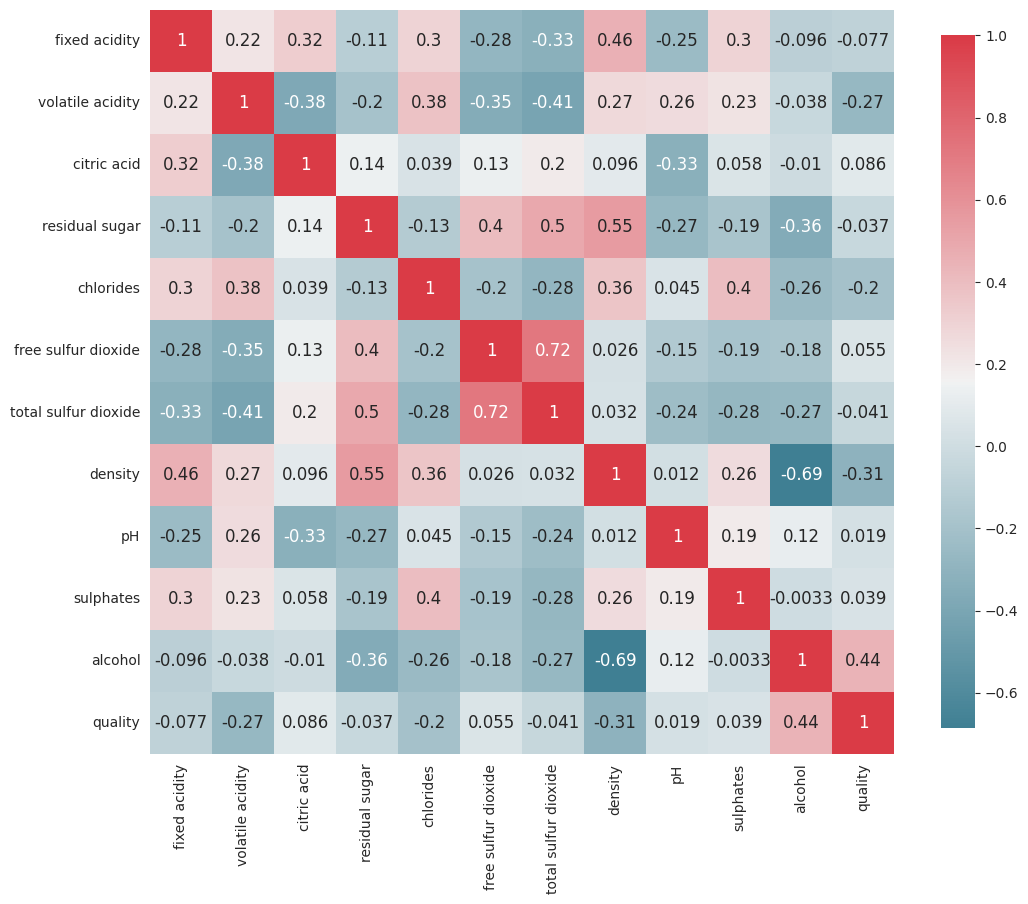

In [9]:
plot_correlation_map( df )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и качеством вина
Начнем с рассмотрения взаимосвязи между алкоголем и качеством

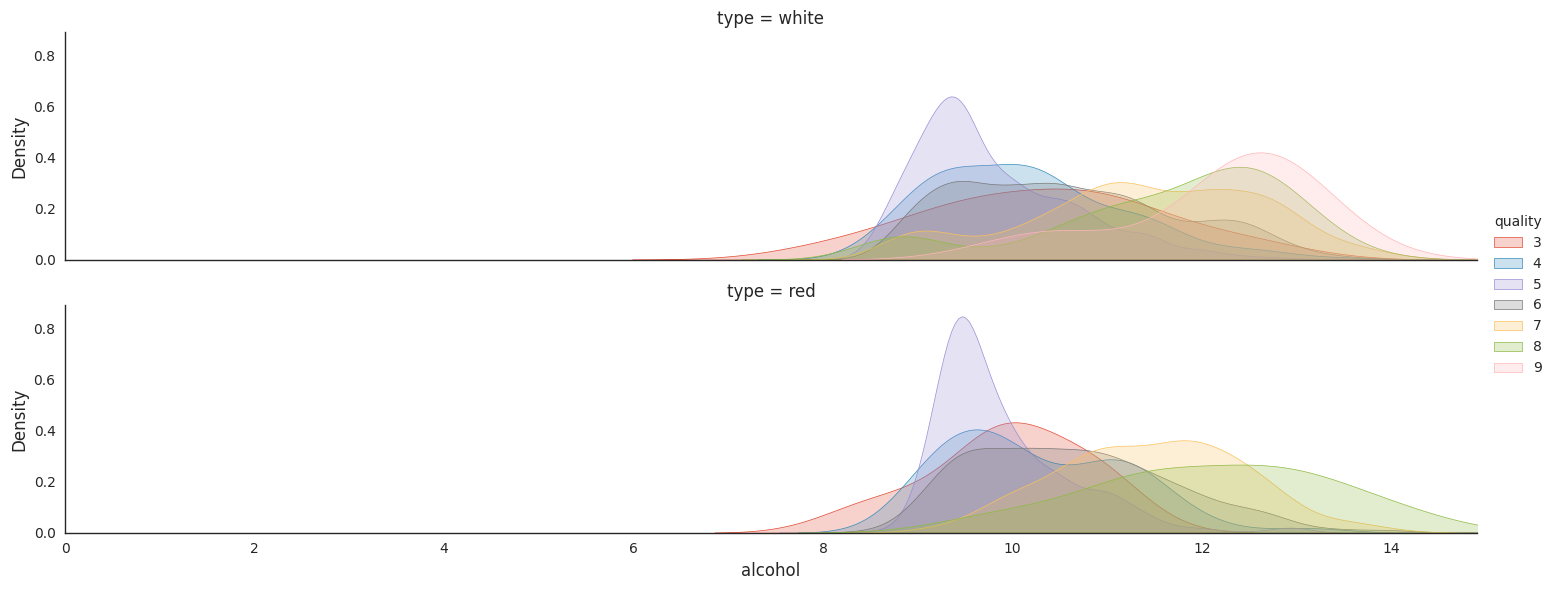

In [12]:
# Plot distributions of alcohol and quality
plot_distribution( df , var = 'alcohol' , target = 'quality' , row = 'type' )

Можно отметить отсутствие 9-ой категории у красного вина, а также наглядно увидеть корреляция: рост алкоголя соответствует более высокому качеству (что в красном, что в белом вине)

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

In [59]:
enc = OneHotEncoder()
enc_data = pd.DataFrame(enc.fit_transform(
    df[['type']]).toarray())
New_df = df.join(enc_data)

In [60]:
New_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,0,1
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0.0,1.0
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0.0,1.0
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0.0,1.0
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.0,1.0
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.0,1.0


## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [61]:
New_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  0                     6497 non-null   float64
 14  1                     6497 non-null   float64
dtypes: float64(13), int64

Учитывая, что пропусков очень мало, просто исключаем их из исследования

In [63]:
New_df.dropna(inplace = True)

## 3.3 Сборка финальных датасетов для моделирования

### 3.3.1 Создание датасетов

Отделяем данные для обучения и для проверки

In [80]:
X = New_df.drop(columns = ['quality','type','total sulfur dioxide'])
Y = New_df['quality']

In [81]:
d = normalize(X, axis=0)
X = pd.DataFrame(d,columns = X.columns.astype(str))
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,0,1
0,0.011873,0.008899,0.012784,0.035618,0.008465,0.015854,0.012518,0.011581,0.010147,0.010365,0.0,0.01433
1,0.010686,0.009888,0.012074,0.002753,0.009218,0.004932,0.012430,0.012739,0.011049,0.011190,0.0,0.01433
2,0.013739,0.009229,0.014204,0.011873,0.009406,0.010569,0.012444,0.012584,0.009922,0.011897,0.0,0.01433
3,0.012212,0.007581,0.011363,0.014626,0.010911,0.016558,0.012450,0.012314,0.009020,0.011661,0.0,0.01433
4,0.012212,0.007581,0.011363,0.014626,0.010911,0.016558,0.012450,0.012314,0.009020,0.011661,0.0,0.01433


In [82]:
train_X , test_X , train_y , test_y = train_test_split( X , Y , train_size = .7 )

### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


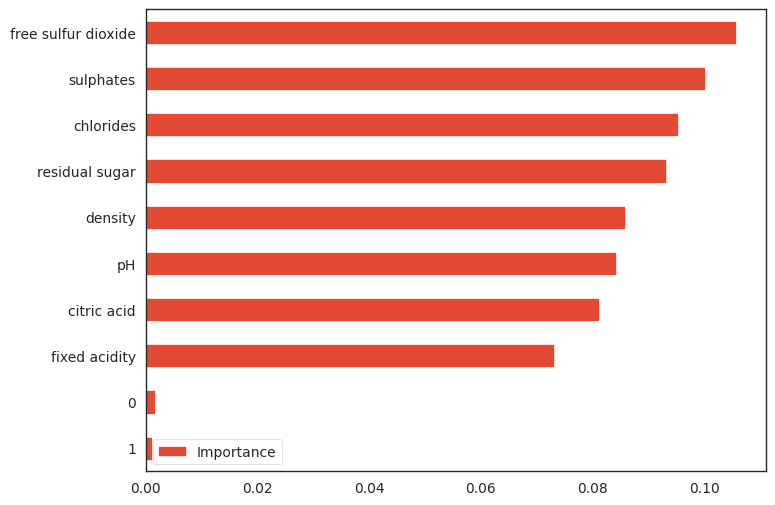

In [83]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [84]:
model = LogisticRegression()

## 4.2 Обучение модели

In [85]:
model.fit( train_X , train_y )

LogisticRegression()

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [86]:
# Score the model
print (model.score( train_X , train_y ) , model.score( test_X , test_y ))

0.4407603890362511 0.4265085095410005


In [88]:
#попробуем улучшить модель, оставив только "важные" переменные
X2 = New_df[['free sulfur dioxide', 'sulphates', 'chlorides', 'residual sugar', 'density', 'pH', 'citric acid', 'fixed acidity']]

In [89]:
train_X2 , test_X2 , train_y , test_y = train_test_split( X2 , Y , train_size = .7 )

In [90]:
model.fit( train_X2 , train_y )

LogisticRegression()

In [91]:
print (model.score( train_X2 , train_y ) , model.score( test_X2 , test_y ))

0.4301503094606543 0.4321815368746777
